In [1]:

import pandas as pd
import time
import numpy as np
import tensorflow as tf
import re
import matplotlib.pyplot as plt
import nltk
import string

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.python.ops.resource_variable_ops import var_handle_op
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
from transformers import AutoTokenizer, AutoModel, TFAutoModel
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import KFold

nltk.download('stopwords') # download stopwords corpus
nltk.download('punkt') # download punkt tokenizer




2023-06-14 15:46:37.272643: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/modelenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Hannah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Hannah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
%cd /Users/Hannah/Documents/VU/Msc/Thesis/Coding/Pipeline

/Users/Hannah/Documents/VU/Msc/Thesis/Coding/Pipeline


Some layers from the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_6 (TFBertModel)  TFBaseModelOutputWi  109137408   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

2023-06-12 14:13:23.080376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype double and shape [4629]
	 [[{{node Placeholder/_3}}]]
/opt/anaconda3/envs/modelenv/lib/python3.11/site-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2023-06-12 14:25:48.537992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype double and shape [992]
	 [[{{node Placeholder/_3}}]]
2023-06-12 16:44:05.562278: I tensorflow

31/31 [==============================] - 142s 4s/step
Best Model: Mean Squared Error: 0.10815490416533455
Language Model: Variance of Errors: 0.10808139785731423
Language Model: Standard Deviation of Errors: 0.3287573540733564


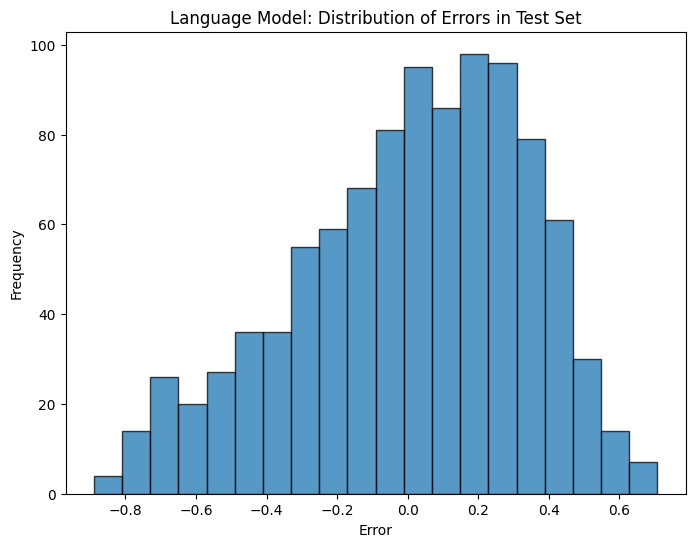

In [15]:

# Load the data
df = pd.read_csv('Indicator-Desc_DataNewVanPipeline.csv')
X = df['content']
y = df['entropy']

# split train dataset into train, validation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Plot the distribution of entropy scores in the test set
plt.figure(figsize=(8, 6))
plt.hist(y_train, bins=20, edgecolor='black', color='grey', alpha=0.75)
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.title('Language model: Distribution of Entropy Scores in Train Set')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(y_test, bins=20, edgecolor='black', color='grey', alpha=0.75)
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.title('Language model: Distribution of Entropy Scores in Test Set')
plt.show()


# BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")

# Tokenize and encode the text data
train_tokens = tokenizer.batch_encode_plus(
    X_train.values.tolist(),
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

# Tokenize and encode the text data
val_tokens = tokenizer.batch_encode_plus(
    X_val.values.tolist(),
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

test_tokens = tokenizer.batch_encode_plus(
    X_test.values.tolist(),
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

# Convert the tokenized input to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_tokens),
    y_train.values
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_tokens),
    y_val.values
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_tokens),
    y_test.values
))

# Prepare the model input
input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

# Load BERT model
model = TFAutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")  # Tensorflow

# Freeze BERT layers
model.trainable = False

# Retrieve the BERT embeddings
embeddings = model(input_ids,attention_mask)[0]

# Perform pooling (average pooling in this case)
pooled_output = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
pooled_output = tf.keras.layers.Dropout(0.1)(pooled_output)
pooled_output = tf.keras.layers.Dense(32, activation='relu')(pooled_output)
pooled_output = tf.keras.layers.Dropout(0.1)(pooled_output)

# Dense layer for regression output
output = tf.keras.layers.Dense(1, activation='linear')(pooled_output)

# Build the model
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile the model, learning rate: 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), loss='mean_squared_error')

model.summary()



training = model.fit(train_dataset.batch(256), epochs=10, shuffle=True, verbose=0, validation_data=val_dataset.batch(256))

# Evaluate the best model on the test set
predictions = model.predict(test_dataset.batch(32))
mse = mean_squared_error(y_test.values, predictions)
print('Best Model: Mean Squared Error:', mse)
#print('Best Hyperparameters:', best_params)


# Calculate the errors
errors = y_test.values - predictions.flatten()

# Calculate the variance and standard deviation of errors
var = np.var(errors)
std = np.std(errors)
print('Language Model: Variance of Errors:', var)
print('Language Model: Standard Deviation of Errors:', std)

# Plot the distribution of errors
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=20, edgecolor='black', alpha=0.75)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Language Model: Distribution of Errors in Test Set')
plt.show()


 Resources:
 https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794


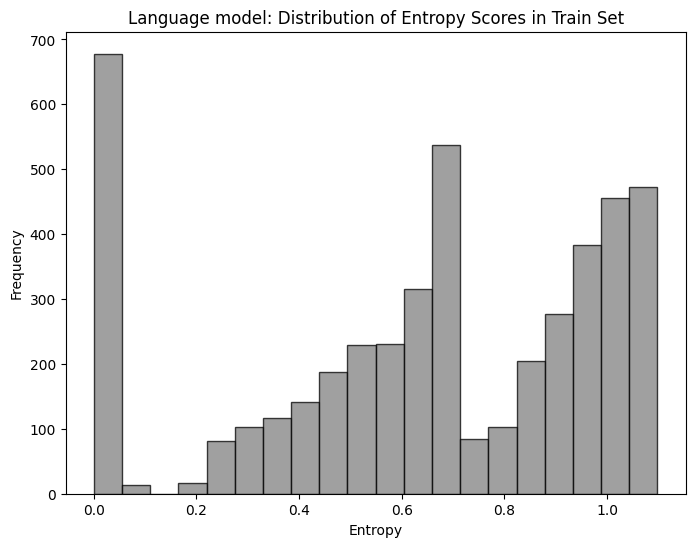

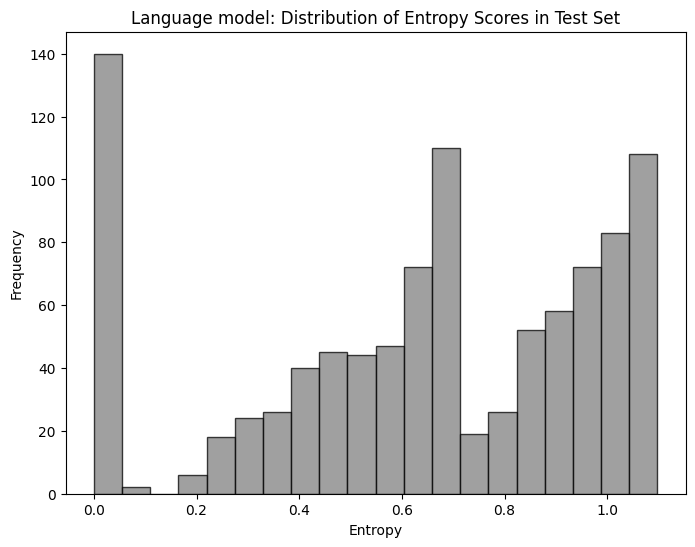

Some layers from the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  109137408   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

2023-06-19 23:15:16.796886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype double and shape [3703]
	 [[{{node Placeholder/_3}}]]
/opt/anaconda3/envs/modelenv/lib/python3.11/site-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2023-06-19 23:44:14.730506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype double and shape [926]
	 [[{{node Placeholder/_3}}]]
2023-06-20 04:42:49.901412: I tensorflow

29/29 [==============================] - 336s 11s/step


2023-06-20 04:48:31.679758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype double and shape [3703]
	 [[{{node Placeholder/_3}}]]
2023-06-20 05:14:49.062297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype double and shape [926]
	 [[{{node Placeholder/_3}}]]


In [5]:
# Load the data
df = pd.read_csv('Indicator-Desc_DataNewVanPipeline.csv')
X = df['content']
y = df['entropy']

# split train dataset into train, validation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Plot the distribution of entropy scores in the test set
plt.figure(figsize=(8, 6))
plt.hist(y_train, bins=20, edgecolor='black', color='grey', alpha=0.75)
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.title('Language model: Distribution of Entropy Scores in Train Set')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(y_test, bins=20, edgecolor='black', color='grey', alpha=0.75)
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.title('Language model: Distribution of Entropy Scores in Test Set')
plt.show()

# BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")

# Tokenize and encode the text data
train_tokens = tokenizer.batch_encode_plus(
    X_train.values.tolist(),
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

# Tokenize and encode the text data
val_tokens = tokenizer.batch_encode_plus(
    X_val.values.tolist(),
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

test_tokens = tokenizer.batch_encode_plus(
    X_test.values.tolist(),
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

# Convert the tokenized input to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_tokens),
    y_train.values
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_tokens),
    y_val.values
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_tokens),
    y_test.values
))

# Prepare the model input
input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

# Load BERT model
model = TFAutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")  # Tensorflow

# Freeze BERT layers
model.trainable = False

# Retrieve the BERT embeddings
embeddings = model(input_ids,attention_mask)[0]

# Perform pooling (average pooling in this case)
pooled_output = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
pooled_output = tf.keras.layers.Dropout(0.1)(pooled_output)
pooled_output = tf.keras.layers.Dense(32, activation='relu')(pooled_output)
pooled_output = tf.keras.layers.Dropout(0.1)(pooled_output)

# Dense layer for regression output
output = tf.keras.layers.Dense(1, activation='linear')(pooled_output)

# Build the model
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile the model, learning rate: 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), loss='mean_squared_error')

model.summary()

# Define the number of folds for cross-validation
num_folds = 5

# Perform k-fold cross-validation
kf = KFold(n_splits=num_folds, shuffle=True)

mse_scores = []
var_scores = []
std_scores = []

for train_index, val_index in kf.split(X_train):
    
    # Split the train set into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Tokenize and encode the text data for the current fold
    train_tokens_fold = tokenizer.batch_encode_plus(
        X_train_fold.values.tolist(),
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='tf'
    )

    val_tokens_fold = tokenizer.batch_encode_plus(
        X_val_fold.values.tolist(),
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='tf'
    )

    # Convert the tokenized input to TensorFlow Dataset for the current fold
    train_dataset_fold = tf.data.Dataset.from_tensor_slices((
        dict(train_tokens_fold),
        y_train_fold.values
    ))

    val_dataset_fold = tf.data.Dataset.from_tensor_slices((
        dict(val_tokens_fold),
        y_val_fold.values
    ))

    # Fit the model on the current fold
    training = model.fit(train_dataset_fold.batch(256), epochs=10, shuffle=True, verbose=0, validation_data=val_dataset_fold.batch(256))

    # Evaluate the model on the validation set of the current fold
    predictions = model.predict(val_dataset_fold.batch(32))
    mse = mean_squared_error(y_val_fold.values, predictions)
    mse_scores.append(mse)

    # Calculate the errors on the validation set of the current fold
    errors = y_val_fold.values - predictions.flatten()

    # Calculate the variance and standard deviation of errors for the current fold
    var = np.var(errors)
    std = np.std(errors)
    var_scores.append(var)
    std_scores.append(std)

# Calculate the average MSE, variance, and standard deviation across all folds
avg_mse = np.mean(mse_scores)
avg_var = np.mean(var_scores)
avg_std = np.mean(std_scores)

print('Average MSE across all folds:', avg_mse)
print('Average variance across all folds:', avg_var)
print('Average standard deviation across all folds:', avg_std)

# Evaluate the best model on the test set
predictions = model.predict(test_dataset.batch(32))
mse = mean_squared_error(y_test.values, predictions)
print('Best Model: Mean Squared Error:', mse)

# Calculate the errors
errors = y_test.values - predictions.flatten()

# Calculate the variance and standard deviation of errors
var = np.var(errors)
std = np.std(errors)
print('Language Model: Variance of Errors:', var)
print('Language Model: Standard Deviation of Errors:', std)

# Plot the distribution of errors
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=20, edgecolor='black', color='grey', alpha=0.75)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Language Model: Distribution of Errors in Test Set')
plt.show()

